In [1]:
pip install p_tqdm

  Created wheel for p-tqdm: filename=p_tqdm-1.3.3-py3-none-any.whl size=3988 sha256=9a8bea8d7962841f0b42f165113d09ffe1f16d00b4dad709247af1d907d1f4c0
  Stored in directory: /root/.cache/pip/wheels/57/6c/d6/8c4cc7d253ecfdfe0fb49f5a754d33e9c2ce1664935325b1b6
Successfully built p-tqdm
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt # visualization
import re
from p_tqdm import p_map

# image handling
import cv2
import urllib
from urllib import request

# modeling
import tensorflow as tf
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras import layers
from keras.optimizers import SGD

import os

# 1. Read in Data

In [3]:
# read in the app data from kaggle directors; because this analysis is focusing on images, we only need the name, icon URL, and app genre
data = pd.read_csv('/kaggle/input/17k-apple-app-store-strategy-games/appstore_games.csv',usecols=[2,4,15]) 

# 2. Preprocess Metadata

In [4]:
# parse the genre data to the most granular level of specificity using regular expressions
data['Genre Class'] = data['Genres'].apply(lambda x: re.sub(', Strategy','',re.sub('Strategy, ','',re.sub('Games, ','',x))).split(",")[0])

In [5]:
# let's check out the structure of the data
data.head(10)

,Name,Icon URL,Genres,Genre Class
0,Sudoku,https://is2-ssl.mzstatic.com/image/thumb/Purpl...,"Games, Strategy, Puzzle",Puzzle
1,Reversi,https://is4-ssl.mzstatic.com/image/thumb/Purpl...,"Games, Strategy, Board",Board
2,Morocco,https://is5-ssl.mzstatic.com/image/thumb/Purpl...,"Games, Board, Strategy",Board
3,Sudoku (Free),https://is3-ssl.mzstatic.com/image/thumb/Purpl...,"Games, Strategy, Puzzle",Puzzle
4,Senet Deluxe,https://is1-ssl.mzstatic.com/image/thumb/Purpl...,"Games, Strategy, Board, Education",Board
5,Sudoku - Classic number puzzle,https://is1-ssl.mzstatic.com/image/thumb/Purpl...,"Games, Entertainment, Strategy, Puzzle",Entertainment
6,Gravitation,https://is5-ssl.mzstatic.com/image/thumb/Purpl...,"Games, Entertainment, Puzzle, Strategy",Entertainment
7,Colony,https://is5-ssl.mzstatic.com/image/thumb/Purpl...,"Games, Strategy, Board",Board
8,Carte,https://is3-ssl.mzstatic.com/image/thumb/Purpl...,"Games, Strategy, Board, Entertainment",Board
9,"""Barrels O' Fun""",https://is4-ssl.mzstatic.com/image/thumb/Purpl...,"Games, Casual, Strategy",Casual


In [6]:
# let's check out the different classes...
data['Genre Class'].unique()

array(['Puzzle', 'Board', 'Entertainment', 'Casual', 'Card', 'Finance',
       'Word', 'Action', 'Sports', 'Family', 'Strategy', 'Role Playing',
       'Simulation', 'Adventure', 'Education', 'Travel', 'Navigation',
       'Reference', 'Lifestyle', 'Social Networking', 'Medical', 'Casino',
       'Utilities', 'Trivia', 'Books', 'Racing', 'Music', 'Productivity',
       'Food & Drink', 'Health & Fitness', 'Photo & Video', 'News',
       'Business', 'Stickers', 'Shopping', 'Magazines & Newspapers'],
      dtype=object)

In [7]:
# ... and their distribution
data['Genre Class'].value_counts().apply(lambda x: x/len(data['Genre Class'].values))

Entertainment             0.242606
Puzzle                    0.157641
Simulation                0.088846
Action                    0.085553
Casual                    0.067796
Board                     0.067737
Role Playing              0.047804
Education                 0.036162
Strategy                  0.034574
Adventure                 0.032398
Family                    0.025989
Sports                    0.024402
Card                      0.023461
Trivia                    0.009290
Utilities                 0.007585
Lifestyle                 0.006821
Racing                    0.005233
Word                      0.004469
Social Networking         0.004469
Reference                 0.003646
Music                     0.003528
Travel                    0.002940
Productivity              0.002528
Casino                    0.002234
Finance                   0.002176
Stickers                  0.001764
Business                  0.001588
Food & Drink              0.001529
Books               

In [8]:
# and let's create a class weight dictionary to potentially handle the imbalanced nature in the modeling stage
class_distribution = data['Genre Class'].value_counts().apply(lambda x: x/len(data['Genre Class'].values)).reset_index().drop('index',axis=1).to_dict()['Genre Class']

In [9]:
# for the initial proof of concept, let's just focus in on the top two classes and see if we can distinguish them with a reasonable degree of accuracy
# both have counts >2500, so we can filter them out with this information
data['Genre Class Count'] = data['Genre Class'].map(pd.DataFrame(data['Genre Class'].value_counts()).to_dict()['Genre Class'])
data = pd.DataFrame(data[data['Genre Class Count']>2500])

# 3. Load and Preprocess Images

In [10]:
# let's pull the original 512x512 image here
def load_image(pngfile):
    content = request.urlopen(pngfile)
    im = np.asarray(bytearray(content.read()), dtype="uint8")
    return cv2.cvtColor(cv2.imdecode(im,cv2.IMREAD_COLOR), cv2.COLOR_BGR2RGB)/255

In [11]:
# let's tune which interpolation method we use based on manual inspection
def load_resize_image(pngfile,interpolation):
    content = request.urlopen(pngfile)
    im = np.asarray(bytearray(content.read()), dtype="uint8")
    return cv2.resize(cv2.cvtColor(cv2.imdecode(im,cv2.IMREAD_COLOR), cv2.COLOR_BGR2RGB), dsize=(64, 64), interpolation=interpolation)/255

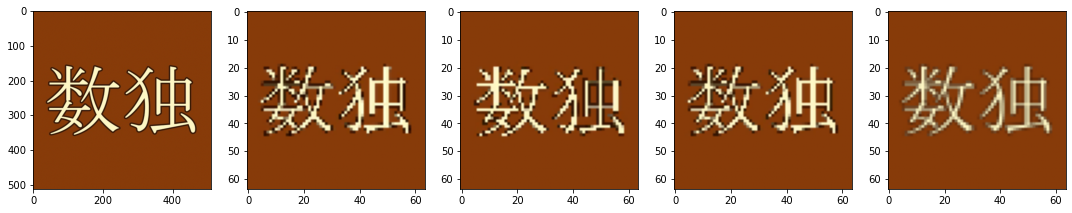

In [12]:
# the leftmost image is the original, and it appears that the rightmost interpolation method retains 
# the most integrity of the original image so let's go with the INTER_AREA method
f, axarr = plt.subplots(1,5)
f.set_size_inches(18.5, 10.5, forward=True)
axarr[0].imshow(load_image(data['Icon URL'].tolist()[0]))
axarr[1].imshow(load_resize_image(data['Icon URL'].tolist()[0],interpolation=cv2.INTER_CUBIC))
axarr[2].imshow(load_resize_image(data['Icon URL'].tolist()[0],interpolation=cv2.INTER_NEAREST))
axarr[3].imshow(load_resize_image(data['Icon URL'].tolist()[0],interpolation=cv2.INTER_LINEAR))
axarr[4].imshow(load_resize_image(data['Icon URL'].tolist()[0],interpolation=cv2.INTER_AREA))

In [13]:
# let's redefine the load_resize_image function using the interpolation method we chose for easier use 
# in the multiprocessing step
def load_resize_image(pngfile):
    content = request.urlopen(pngfile)
    im = np.asarray(bytearray(content.read()), dtype="uint8")
    return cv2.resize(cv2.cvtColor(cv2.imdecode(im,cv2.IMREAD_COLOR), cv2.COLOR_BGR2RGB), dsize=(64, 64), interpolation=cv2.INTER_AREA)/255

In [14]:
# for the POC, let's load the first 5000 images, speeding up with multiprocessing and progress bar
images = np.asarray(p_map(load_resize_image,data['Icon URL'].tolist()[:5000]))

In [15]:
# save and download the images as a .npy file so we don't have to load images again in event of 
# notebook crashing
np.save("images_poc.npy",images)
# np.load("y_dev.npy")

In [16]:
# check that the data has been properly normalized; should be between 0 and 1
[np.min(images[100]),np.max(images[100])]

[0.0, 1.0]

In [17]:
# check the distribution of the data between the two classes
data['Genre Class'].iloc[:5000].apply(lambda x: 1 if x=='Puzzle' else 0).value_counts()

0    3088
1    1912
Name: Genre Class, dtype: int64

In [18]:
# to help with the imbalanced classes, perform oversampling to match the density of them together
images = np.append(images,images[data['Genre Class'].iloc[:5000].apply(lambda x: 1 if x=='Puzzle' else 0).values[:5000]==1][:1176],axis=0)

In [19]:
np.save("images_poc_oversampled.npy",images)
# images_oversampled = np.load("images_poc_oversampled.npy")

In [20]:
# verify that the shape of the images is 6176x64x64x3
images.shape

(6176, 64, 64, 3)

In [21]:
# perform the train vs validation split
from sklearn.model_selection import train_test_split
y_values = np.append(data['Genre Class'].apply(lambda x: 1 if x=='Puzzle' else 0).values[:5000],[1]*1176)
X_train, X_dev, y_train, y_dev = train_test_split(images,y_values, test_size=0.15)

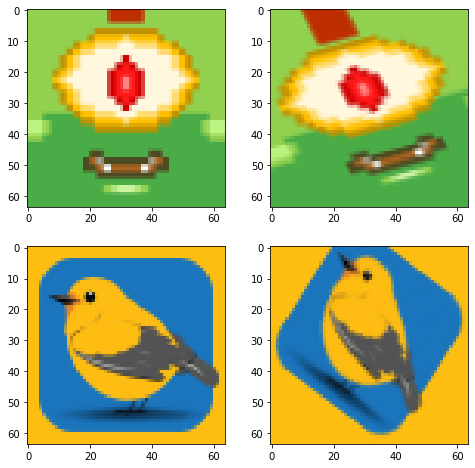

In [22]:
# let's take a look at the transformations that keras's image data generator will be performing
from keras.preprocessing.image import ImageDataGenerator
imgen = ImageDataGenerator(rotation_range=60, width_shift_range=.1,height_shift_range=.1,horizontal_flip=True,zoom_range=0.2)

f, axarr = plt.subplots(2,2)
f.set_size_inches(8, 8, forward=True)
axarr[0][0].imshow(X_train[0])
axarr[1][0].imshow(X_train[1])
axarr[0][1].imshow(imgen.random_transform(X_train[0]))
axarr[1][1].imshow(imgen.random_transform(X_train[1]))

# 4. Modeling

In [38]:
def scheduler(epoch, lr):
    if epoch < 350:
        return lr
    else:
        return .05

with tf.device('/gpu:0'):
    input_dim = X_train.shape[1:]
    model = Sequential()
    
    model.add(layers.Conv2D(64, kernel_size=(3,3), input_shape=input_dim,kernel_initializer='random_normal'))
    model.add(layers.Activation('tanh'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(layers.Dropout(.25))
    
    model.add(layers.Conv2D(128, kernel_size=(3,3), input_shape=input_dim,kernel_initializer='random_normal'))
    model.add(layers.Activation('tanh'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(layers.Dropout(.25))


    model.add(layers.Flatten())

    model.add(layers.Dense(512, activation='tanh',kernel_initializer='random_normal'))
    
    model.add(layers.Dense(1, activation='sigmoid'))
    
    model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),optimizer=SGD(learning_rate=.05),metrics=["accuracy"])
    
    model.summary()
    
    # the image data generator seemed to introduce too much randomness into the model, preventing it from 
    # learning, so I went ahead with just the original data, no data augmentation performed:
    
#     datagen = ImageDataGenerator(rotation_range=60,horizontal_flip=True,zoom_range=0.2)

#     history = model.fit(datagen.flow(X_train,y_train,batch_size=64),steps_per_epoch=len(X_train) / 64,
#                         epochs=1000,
#                         verbose=True,
#                         validation_data=(X_dev, y_dev))
    
    # I also tried a learning rate scheduler to improve the optimization, but this did not result in 
    # increased accuracy
    
#     callback = tf.keras.callbacks.LearningRateScheduler(scheduler)
    
#     history = model.fit(X_train, y_train,
#                         epochs=600,
#                         verbose=True,
#                         callbacks=[callback],
#                         validation_data=(X_dev, y_dev),
#                         batch_size=64) 
    
    # the original model without data augmentation and without a learning rate scheduler ended up 
    # achieving the highest accuracy; there is still overfitting, to be discussed in results section
    
    history = model.fit(X_train, y_train,
                        epochs=500,
                        verbose=False,
                        validation_data=(X_dev, y_dev),
                        batch_size=64)

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 62, 62, 64)        1792      
_________________________________________________________________
activation_10 (Activation)   (None, 62, 62, 64)        0         
_________________________________________________________________
batch_normalization_10 (Batc (None, 62, 62, 64)        256       
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 31, 31, 64)        0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 31, 31, 64)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 29, 29, 128)       73856     
_________________________________________________________________
activation_11 (Activation)   (None, 29, 29, 128)      

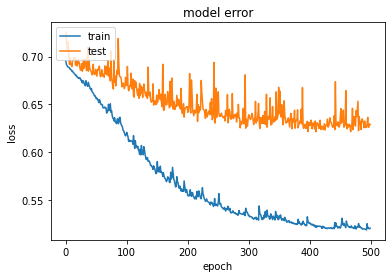

In [39]:
# let's plot the loss history 
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model error')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

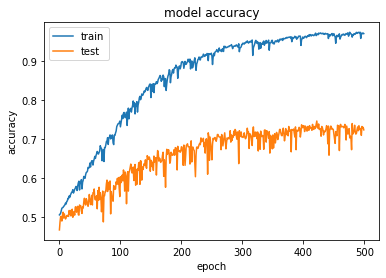

In [40]:
# ... and the accuracy history
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# 5. Tuning the number of epochs
From the learning curves above, we can use the elbow method to find an appropriate cutoff for the number of epochs so as to minimize the overfitting

In [35]:
# rerunning the model with the chosen number of epochs:
with tf.device('/gpu:0'):
    input_dim = X_train.shape[1:]
    model = Sequential()
    
    model.add(layers.Conv2D(64, kernel_size=(3,3), input_shape=input_dim,kernel_initializer='random_normal'))
    model.add(layers.Activation('tanh'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(layers.Dropout(.25))
    
    model.add(layers.Conv2D(128, kernel_size=(3,3), input_shape=input_dim,kernel_initializer='random_normal'))
    model.add(layers.Activation('tanh'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(layers.Dropout(.25))


    model.add(layers.Flatten())

    model.add(layers.Dense(512, activation='tanh',kernel_initializer='random_normal'))
    
    model.add(layers.Dense(1, activation='sigmoid'))
    
    model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),optimizer=SGD(learning_rate=.05),metrics=["accuracy"])
    
    model.summary()
    
    history = model.fit(X_train, y_train,
                    epochs=250,
                    verbose=False,
                    validation_data=(X_dev, y_dev),
                    batch_size=64)

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 62, 62, 64)        1792      
_________________________________________________________________
activation_8 (Activation)    (None, 62, 62, 64)        0         
_________________________________________________________________
batch_normalization_8 (Batch (None, 62, 62, 64)        256       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 31, 31, 64)        0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 31, 31, 64)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 29, 29, 128)       73856     
_________________________________________________________________
activation_9 (Activation)    (None, 29, 29, 128)      

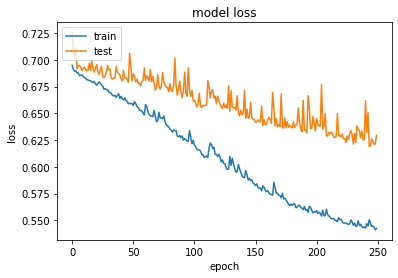

In [36]:
# let's plot the loss history 
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

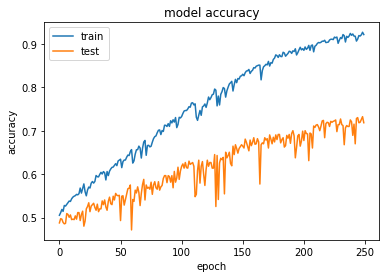

In [37]:
# ... and the accuracy history
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# 6. Results and Discussion
From the modeling, we were able to achieve an accuracy of around 73%, which is better than the baseline of ~60% (from always guessing entertainment pre-oversampling .242606/(.242606+.157641)). However, there are two major problems that preclude a higher accuracy:
1. Overfitting due to the low volume of images
2. High intra-class variation due to the subjective nature of the classes (i.e. what constitutes a puzzle game vs an entertainment game?). Because they are not strictly defined, we would expect higher variation present in the individual classes and overlap between them